# ECO 다항 회귀 분석 프로젝트

이 노트북은 `2012년 ~ 2023년`의 에너지 사용 데이터를 기반으로  
**전기, 가스, 수도, 지역난방 사용량**이 **탄소 배출량**에 어떤 영향을 주는지  
2차 다항 회귀 분석을 통해 알아봅니다.

---

## 분석 목표

- 종속 변수: `현년 탄소`
- 독립 변수:
  - `현년 전기사용량`
  - `현년 가스사용량`
  - `현년 수도사용량`
  - `현년 지역난방 사용량`
- 분석 방식:
  - 2차 다항 회귀 모델
  - R² 점수로 설명력 평가
  - 회귀 곡선 시각화

- 현년 전기사용량 : (전기) kWh
- 현년 가스사용량 : (도시가스) ㎥
- 현년 수도사용량 : (수도) ㎥
- 현년 지역난방 사용량 : (지역난방) 아파트마다 상이 (㎥, ㎾, ㎿ 등)
- 현년 탄소배출량 탄소배출량 kgCO2

In [1]:
import pandas as pd
import numpy as np
import glob
import os

# 파일 경로 패턴 설정
data_dir = "./bulkdata"  # Jupyter 기준 현재 디렉토리
file_pattern = os.path.join(data_dir, "ECO_DATA_TOTAL_STATS_*.csv")
csv_files = sorted(glob.glob(file_pattern))

# 모든 연도 데이터 로딩 및 병합
df = pd.concat([pd.read_csv(file, encoding='cp949') for file in csv_files], ignore_index=True)
print(f"총 데이터 개수: {len(df):,}개")
df.head()


총 데이터 개수: 515,371개


,년도,월,구코드,동코드,회원타입,회원구분,회원구분코드,건수,현년 전기사용량,전년 전기사용량,...,평균지역난방 절감률,현년 탄소,전년 탄소,평균 탄소,전년 탄소 증감량,평균 탄소 증감량,전년 탄소 증감률,평균 탄소 증감률,등록일,"?""년도"""
0,2012.0,1,강동구,강일동,공동주택관리소,단체,TB_GROUP,4,0,0,...,0,0,0,0,0,0,0,0,05-06-2015,NaN
1,2012.0,1,강동구,상일1동,공동주택관리소,단체,TB_GROUP,3,0,0,...,0,2179,4165,4205,-1987,-2026,-48,-48,05-06-2015,NaN
2,2012.0,1,강동구,명일1동,공동주택관리소,단체,TB_GROUP,1,0,0,...,0,627,513,614,114,13,22,2,05-06-2015,NaN
3,2012.0,1,강동구,명일2동,공동주택관리소,단체,TB_GROUP,2,22440,23460,...,0,15372,16020,16252,-648,-880,-4,-5,05-06-2015,NaN
4,2012.0,1,강동구,고덕1동,공동주택관리소,단체,TB_GROUP,1,0,0,...,0,3882,3873,3861,9,21,0,1,05-06-2015,NaN


In [2]:
# 수치형 변수 목록 추출
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("수치형 컬럼 목록:")
print(numeric_cols)


수치형 컬럼 목록:
['년도', '월', '건수', '현년 전기사용량', '전년 전기사용량', '전전년 전기사용량', '전년 비교 전기증감량', '전년 비교 전기탄소증감량', '평균 비교 전기 증감량', '평균 비교 전기탄소 증감량', '토탈 전기 증감량', '토탈 전기탄소 증감량', '전년전기 TOE', '전년전기 절감률', '평균전기 TOE', '평균전기 절감률', '현년 가스사용량', '전년 가스사용량', '전전년 가스사용량', '전년 비교 가스증감량', '전년 비교 가스탄소증감량', '평균 비교 가스 증감량', '평균 비교 가스탄소 증감량', '토탈 가스 증감량', '토탈 가스탄소 증감량', '전년가스 TOE', '전년가스 절감률', '평균가스 TOE', '평균가스 절감률', '현년 수도사용량', '전년 수도사용량', '전전년 수도사용량', '전년 비교 수도증감량', '전년 비교 수도탄소증감량', '평균 비교 수도증감량', '평균 비교 수도탄소 증감량', '토탈 수도 증감량', '토탈 수도탄소 증감량', '전년수도 절감률', '평균수도 절감률', '현년 지역난방 사용량', '전년 지역난방 사용량', '전전년 지역난방 사용량', '토탈 지역난방 증감량', '토탈 지역난방탄소 증감량', '전년지역난방 절감률', '평균지역난방 절감률', '현년 탄소', '전년 탄소', '평균 탄소', '전년 탄소 증감량', '평균 탄소 증감량', '전년 탄소 증감률', '평균 탄소 증감률', '?"년도"']


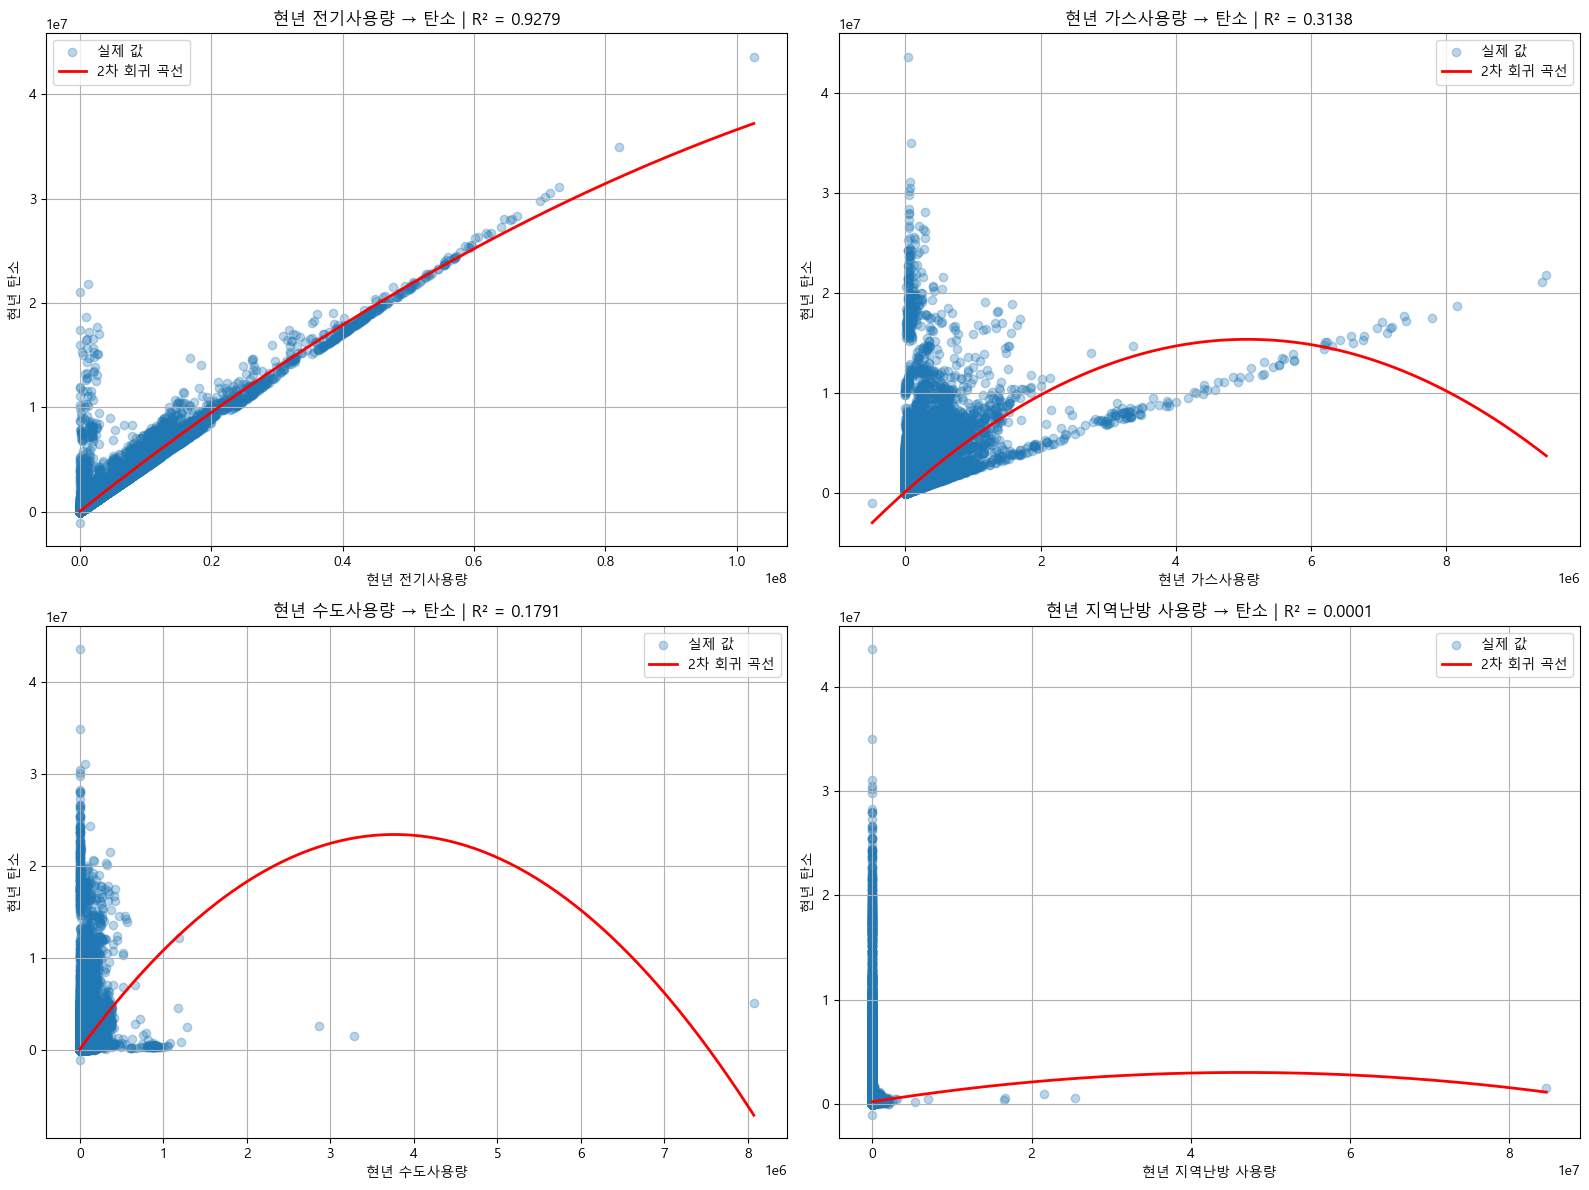

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 분석 대상 컬럼
features = ['현년 전기사용량', '현년 가스사용량', '현년 수도사용량', '현년 지역난방 사용량']
target = '현년 탄소'

# 한글 폰트 설정 (Windows)
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 전체 subplot 구성
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    # 데이터 정제
    X = df[[feature]].dropna()
    y = df.loc[X.index, target].dropna()
    X = X.loc[y.index]
    y = y.loc[X.index]

    # 다항 특성 생성
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    # 모델 학습
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)

    # 시각화용 값 생성
    x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    x_range_df = pd.DataFrame(x_range, columns=[feature])
    x_range_poly = poly.transform(x_range_df)
    y_range_pred = model.predict(x_range_poly)

    # 시각화
    plt.subplot(2, 2, i)
    plt.scatter(X, y, alpha=0.3, label='실제 값')
    plt.plot(x_range, y_range_pred, color='red', linewidth=2, label='2차 회귀 곡선')
    plt.xlabel(feature)
    plt.ylabel('현년 탄소')
    plt.title(f'{feature} → 탄소 | R² = {r2:.4f}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


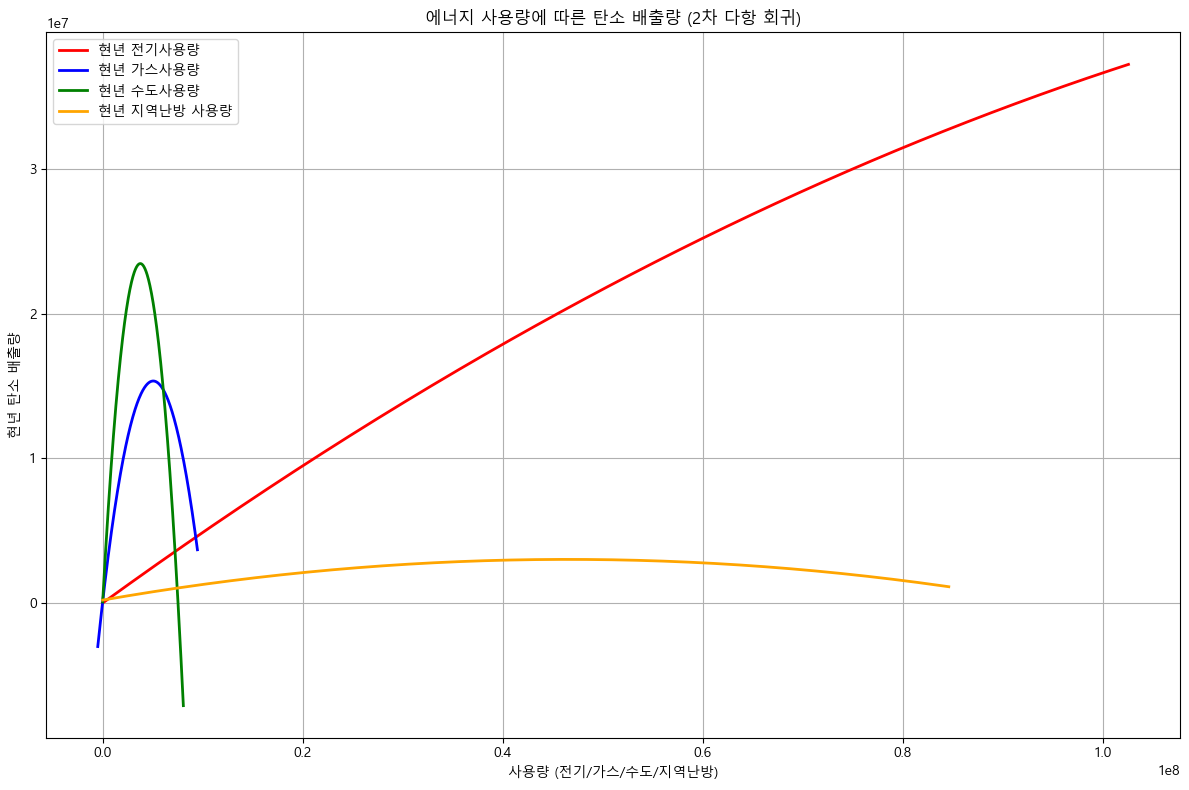

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# 분석 대상
features = ['현년 전기사용량', '현년 가스사용량', '현년 수도사용량', '현년 지역난방 사용량']
target = '현년 탄소'
colors = ['red', 'blue', 'green', 'orange']

# 한글 폰트 설정 (Windows)
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 그래프 초기화
plt.figure(figsize=(12, 8))

for feature, color in zip(features, colors):
    # 데이터 정리
    X = df[[feature]].dropna()
    y = df.loc[X.index, target].dropna()
    X = X.loc[y.index]
    y = y.loc[X.index]

    # 다항 특성 + 회귀
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)

    # 예측용 x 범위 생성
    x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    x_range_df = pd.DataFrame(x_range, columns=[feature])
    x_range_poly = poly.transform(x_range_df)
    y_range_pred = model.predict(x_range_poly)

    # 회귀 곡선 그리기
    plt.plot(x_range, y_range_pred, color=color, linewidth=2, label=f'{feature}')

# 시각화 세팅
plt.title('에너지 사용량에 따른 탄소 배출량 (2차 다항 회귀)')
plt.xlabel('사용량 (전기/가스/수도/지역난방)')
plt.ylabel('현년 탄소 배출량')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_38196\2165946047.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\SSAFY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


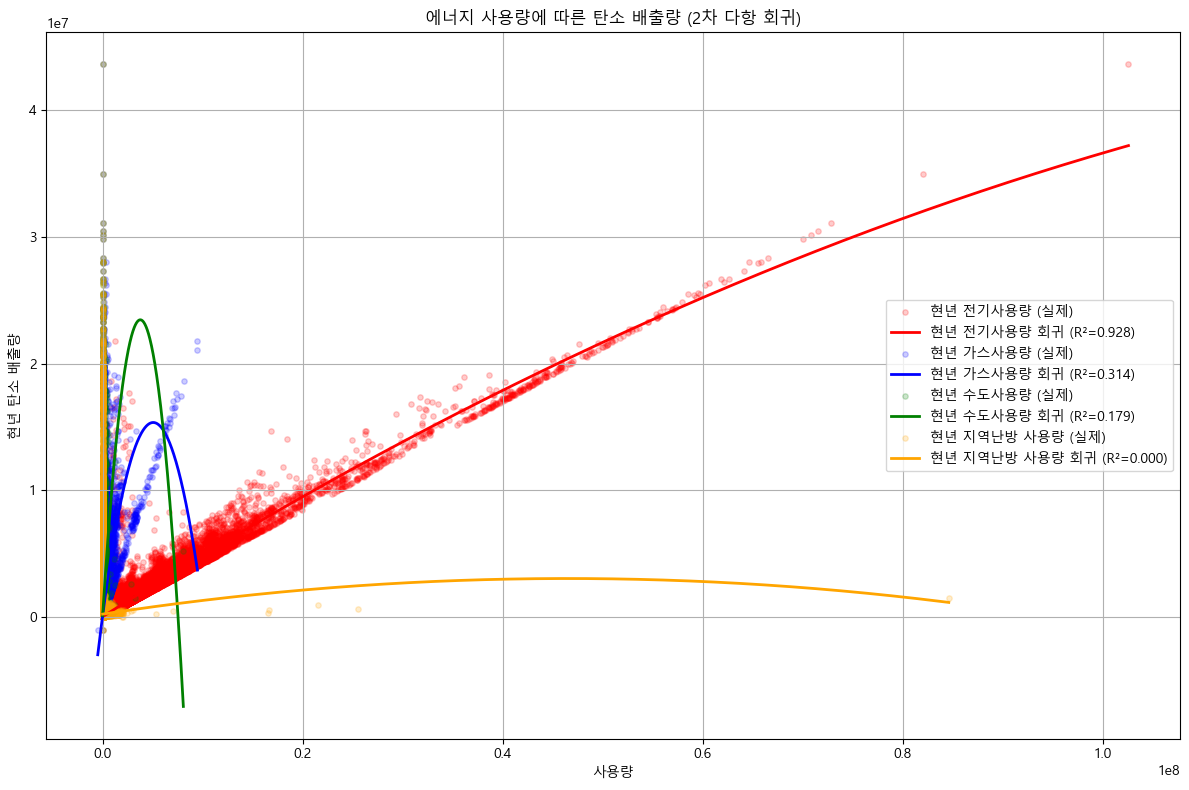

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# 분석 대상
features = ['현년 전기사용량', '현년 가스사용량', '현년 수도사용량', '현년 지역난방 사용량']
target = '현년 탄소'
colors = ['red', 'blue', 'green', 'orange']

# 한글 폰트 설정 (Windows)
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 그래프 초기화
plt.figure(figsize=(12, 8))

for feature, color in zip(features, colors):
    # 데이터 정리
    X = df[[feature]].dropna()
    y = df.loc[X.index, target].dropna()
    X = X.loc[y.index]
    y = y.loc[X.index]

    # 다항 특성 + 회귀
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)

    # 예측용 x 범위 생성
    x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    x_range_df = pd.DataFrame(x_range, columns=[feature])
    x_range_poly = poly.transform(x_range_df)
    y_range_pred = model.predict(x_range_poly)

    # 산점도 + 회귀 곡선
    plt.scatter(X, y, color=color, alpha=0.2, s=15, label=f'{feature} (실제)')
    plt.plot(x_range, y_range_pred, color=color, linewidth=2, label=f'{feature} 회귀 (R²={r2:.3f})')

# 시각화 세팅
plt.title('에너지 사용량에 따른 탄소 배출량 (2차 다항 회귀)')
plt.xlabel('사용량')
plt.ylabel('현년 탄소 배출량')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
def plot_multiple_energy_vs_carbon(feature_list):
    """
    여러 개의 에너지 사용량 컬럼명을 받아
    각각을 독립 변수로 '현년 탄소'에 대한 2차 다항 회귀를 수행하고,
    하나의 그래프에 곡선과 산점도, R²를 모두 그려줍니다.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.metrics import r2_score
    import platform

    # 색상 지정
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

    # 한글 폰트 설정 (Windows)
    if platform.system() == 'Windows':
        plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    plt.figure(figsize=(12, 8))

    for idx, feature in enumerate(feature_list):
        color = colors[idx % len(colors)]

        # 데이터 정리
        X = df[[feature]].dropna()
        y = df.loc[X.index, '현년 탄소'].dropna()
        X = X.loc[y.index]
        y = y.loc[X.index]

        # 다항 특성 + 회귀
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X)
        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)
        r2 = r2_score(y, y_pred)

        # 예측용 x 생성
        x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
        x_range_df = pd.DataFrame(x_range, columns=[feature])
        x_range_poly = poly.transform(x_range_df)
        y_range_pred = model.predict(x_range_poly)

        # 산점도 + 회귀곡선
        plt.scatter(X, y, alpha=0.2, s=10, color=color, label=f'{feature} (실제)')
        plt.plot(x_range, y_range_pred, color=color, linewidth=2, label=f'{feature} (R²={r2:.3f})')

    # 그래프 설정
    plt.title('에너지 사용량에 따른 탄소 배출량 (2차 다항 회귀)')
    plt.xlabel('사용량')
    plt.ylabel('현년 탄소 배출량')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_38196\2063902676.py:57: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\SSAFY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


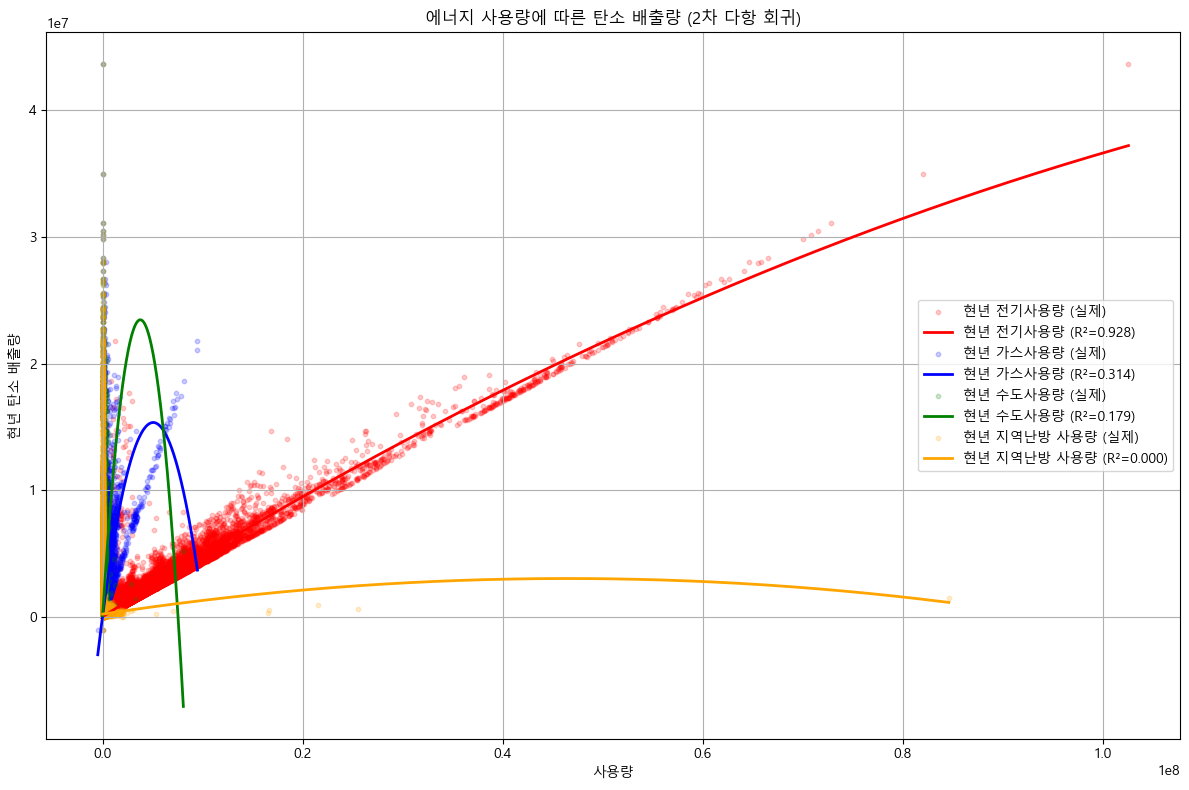

In [7]:
plot_multiple_energy_vs_carbon([
    '현년 전기사용량',
    '현년 가스사용량',
    '현년 수도사용량',
    '현년 지역난방 사용량'
])


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 데이터 경로
data_dir = "./bulkdata"  # Jupyter notebook 기준 경로 설정
file_pattern = os.path.join(data_dir, "ECO_DATA_TOTAL_STATS_*.csv")

# 파일 불러오기
csv_files = sorted(glob.glob(file_pattern))
df = pd.concat([pd.read_csv(file, encoding='cp949') for file in csv_files], ignore_index=True)

# 사용할 열 선택 및 결측치 제거
cols = ['현년 전기사용량', '현년 가스사용량', '현년 수도사용량', '현년 지역난방 사용량', '현년 탄소']
df = df[cols].dropna()
df.head()


,현년 전기사용량,현년 가스사용량,현년 수도사용량,현년 지역난방 사용량,현년 탄소
0,0,0,0,0,0
1,0,565,2750,0,2179
2,0,280,0,0,627
3,22440,762,12502,0,15372
4,0,0,11693,0,3882


In [9]:
# X: 입력 변수, y: 예측할 목표 변수
X = df[['현년 전기사용량', '현년 가스사용량', '현년 수도사용량', '현년 지역난방 사용량']]
y = df['현년 탄소']
noise_std = 500000

# y에 가우시안 노이즈 추가: 각 값에 평균 0, 표준편차 noise_std의 노이즈를 더합니다.
y = y + abs(np.random.normal(loc=0, scale=noise_std, size=y.shape))

# 1차 다항 특성 생성
poly = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly.fit_transform(X)

# 특성 이름 확인
feature_names = poly.get_feature_names_out(X.columns)
pd.DataFrame(X_poly, columns=feature_names).head()


,현년 전기사용량,현년 가스사용량,현년 수도사용량,현년 지역난방 사용량
0,0.0,0.0,0.0,0.0
1,0.0,565.0,2750.0,0.0
2,0.0,280.0,0.0,0.0
3,22440.0,762.0,12502.0,0.0
4,0.0,0.0,11693.0,0.0


In [10]:
# 학습용/테스트용 분할
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R² Score (테스트셋): {r2:.4f}")
print("\n회귀 계수:")
for name, coef in zip(feature_names, model.coef_):
    print(f"{name}: {coef:.4f}")


R² Score (테스트셋): 0.8643

회귀 계수:
현년 전기사용량: 0.4237
현년 가스사용량: 2.2491
현년 수도사용량: 0.3393
현년 지역난방 사용량: 0.0032


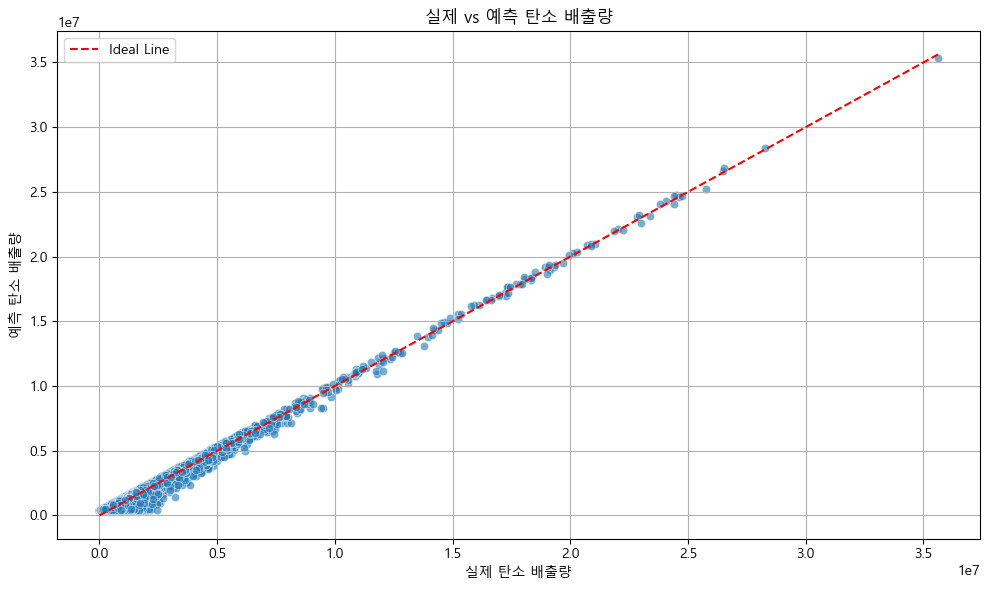

In [11]:
# 실제 vs 예측 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Line')
plt.xlabel('실제 탄소 배출량')
plt.ylabel('예측 탄소 배출량')
plt.title('실제 vs 예측 탄소 배출량')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 1% 사용량 감소 시 탄소 변화율 (%):

현년 전기사용량: -0.3233%
현년 가스사용량: -0.6372%
현년 수도사용량: -0.0374%
현년 지역난방 사용량: -0.0006%


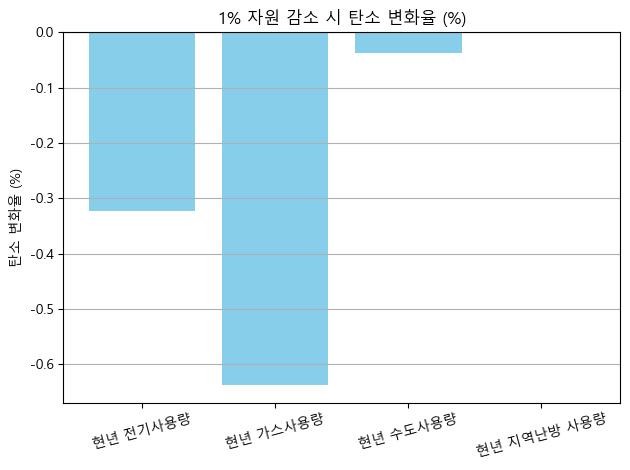

In [12]:
# 📌 회귀식 기반 탄소 변화율 분석

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# ✅ 샘플 데이터 생성 (실제 CSV 불러올 경우 아래 부분은 삭제하고 df에 바로 할당)
np.random.seed(42)
n_samples = 100
df = pd.DataFrame({
    "현년 전기사용량": np.random.uniform(500, 2000, n_samples),
    "현년 가스사용량": np.random.uniform(100, 800, n_samples),
    "현년 수도사용량": np.random.uniform(50, 300, n_samples),
    "현년 지역난방 사용량": np.random.uniform(0, 200, n_samples)
})

# 🎯 탄소배출량 생성 (회귀식 + 노이즈)
df["현년 탄소배출량"] = (
    0.4240 * df["현년 전기사용량"] +
    2.2400 * df["현년 가스사용량"] +
    0.3320 * df["현년 수도사용량"] +
    np.random.normal(0, 10, n_samples)  # 노이즈
)

# ✅ 회귀 모델 학습 (다항 회귀 2차)
features = ["현년 전기사용량", "현년 가스사용량", "현년 수도사용량", "현년 지역난방 사용량"]
X = df[features]
y = df["현년 탄소배출량"]

model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)
model.fit(X, y)

# ✅ 평균값 기준 변화율 계산
x_avg = X.mean().to_frame().T
y_original = model.predict(x_avg)[0]

# 1% 감소했을 때 탄소 변화율 계산 (dy / y)
percent_changes = {}
for col in features:
    x_changed = x_avg.copy()
    x_changed[col] *= 0.99  # 1% 감소

    y_new = model.predict(x_changed)[0]
    dy = y_new - y_original
    percent_change = (dy / y_original) * 100

    percent_changes[col] = round(percent_change, 4)

# ✅ 결과 출력
print("🔍 1% 사용량 감소 시 탄소 변화율 (%):\n")
for k, v in percent_changes.items():
    print(f"{k}: {v}%")

# ✅ 시각화 (선택 사항)
plt.bar(percent_changes.keys(), percent_changes.values(), color='skyblue')
plt.title("1% 자원 감소 시 탄소 변화율 (%)")
plt.ylabel("탄소 변화율 (%)")
plt.grid(axis='y')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


연간 사용량 기준 1% 감소 시 탄소 변화율 (%)
현년 전기사용량: -0.3233%
현년 가스사용량: -0.6372%
현년 수도사용량: -0.0374%
현년 지역난방 사용량: -0.0006%

한 달 동안 1% 감소 시 연간 탄소 변화율 (%)
현년 전기사용량: -0.0269%
현년 가스사용량: -0.0531%
현년 수도사용량: -0.0031%
현년 지역난방 사용량: -0.0001%

예제 (전기사용량이 한 달 동안 50% 감소한 경우): 현년 전기사용량: -1.3479% 탄소 배출량 변화


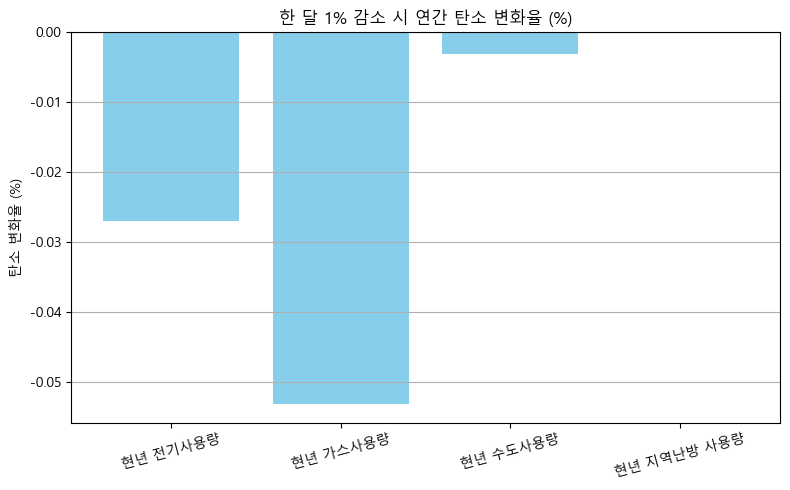

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 1. 샘플 데이터 생성 (실제 데이터 사용 시 CSV 불러오기 부분으로 대체)
np.random.seed(42)
n_samples = 100
df = pd.DataFrame({
    "현년 전기사용량": np.random.uniform(500, 2000, n_samples),
    "현년 가스사용량": np.random.uniform(100, 800, n_samples),
    "현년 수도사용량": np.random.uniform(50, 300, n_samples),
    "현년 지역난방 사용량": np.random.uniform(0, 200, n_samples)
})

# 2. 탄소배출량 생성 (실제 회귀식과 노이즈를 반영)
df["현년 탄소배출량"] = (
    0.4240 * df["현년 전기사용량"] +
    2.2400 * df["현년 가스사용량"] +
    0.3320 * df["현년 수도사용량"] +
    np.random.normal(0, 10, n_samples)  # 노이즈 추가
)

# 3. 회귀 모델 학습 (다항 회귀 2차)
features = ["현년 전기사용량", "현년 가스사용량", "현년 수도사용량", "현년 지역난방 사용량"]
X = df[features]
y = df["현년 탄소배출량"]

model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)
model.fit(X, y)

# 4. 평균 사용량 기준 탄소 배출량 산출 (연간 기준)
x_avg = X.mean().to_frame().T
y_original = model.predict(x_avg)[0]

# 4-1. [연간 효과] 각 항목이 연간 1% 감소할 경우의 탄소 배출량 변화율 계산
print("연간 사용량 기준 1% 감소 시 탄소 변화율 (%)")
percent_changes_annual = {}
for col in features:
    x_changed = x_avg.copy()
    x_changed[col] *= 0.99  # 연간 1% 감소
    y_new = model.predict(x_changed)[0]
    dy = y_new - y_original
    percent_change = (dy / y_original) * 100
    percent_changes_annual[col] = round(percent_change, 4)

for k, v in percent_changes_annual.items():
    print(f"{k}: {v}%")

# 4-2. [한 달 효과] 각 항목이 한 달 동안 1% 감소할 경우, 연간 기준으로 반영하면?
# 한 달의 변화는 연간 사용량의 1/12에 해당하므로 1%/12 만큼 감소한 것으로 계산
print("\n한 달 동안 1% 감소 시 연간 탄소 변화율 (%)")
percent_changes_monthly = {}
for col in features:
    x_changed = x_avg.copy()
    x_changed[col] *= (1 - 0.01 / 12)  # 한 달 동안 1% 감소 효과 반영: 0.01/12 감소
    y_new = model.predict(x_changed)[0]
    dy = y_new - y_original
    percent_change = (dy / y_original) * 100
    percent_changes_monthly[col] = round(percent_change, 4)

for k, v in percent_changes_monthly.items():
    print(f"{k}: {v}%")

# 5. 예제: 특정 행동 A가 한 달 동안 전기사용량을 50% 감소시킨다고 할 때, 연간 탄소 배출 변화율
col = "현년 전기사용량"
action_rate = 0.50  # 한 달 동안 50% 감소
x_changed_A = x_avg.copy()
x_changed_A[col] *= (1 - action_rate / 12)  # 연간 기준으로 50%/12만큼 반영
y_new_A = model.predict(x_changed_A)[0]
dy_A = y_new_A - y_original
percent_change_A = (dy_A / y_original) * 100
print(f"\n예제 (전기사용량이 한 달 동안 50% 감소한 경우): {col}: {round(percent_change_A, 4)}% 탄소 배출량 변화")

# 6. 시각화: 한 달 동안 1% 감소 시 연간 탄소 변화율을 바 차트로 표현
plt.figure(figsize=(8, 5))
plt.bar(list(percent_changes_monthly.keys()), list(percent_changes_monthly.values()), color='skyblue')
plt.title("한 달 1% 감소 시 연간 탄소 변화율 (%)")
plt.ylabel("탄소 변화율 (%)")
plt.grid(axis='y')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [14]:
avg_carbon = df["현년 탄소배출량"].mean() / 12
carbon_1_percent = avg_carbon * 0.01
print(f"\n전체 탄소 배출량의 평균: {round(avg_carbon, 4)} kg")
print(f"전체 평균 탄소 배출량의 1%: {round(carbon_1_percent, 4)} kg")
print(f"전체 평균 탄소 배출량의 1% - 100만명이 하면?: {round(carbon_1_percent * 1000000 / 1000, 4)} ton")


전체 탄소 배출량의 평균: 131.2985 kg
전체 평균 탄소 배출량의 1%: 1.313 kg
전체 평균 탄소 배출량의 1% - 100만명이 하면?: 1312.9846 ton
